### Helpers (Packages and Functions)

In [1]:
#Packages for NLP
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
import string
import nltk
import re
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from textblob import TextBlob, Word
from wordcloud import WordCloud, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')

nlp = spacy.load("en_core_web_sm")

In [2]:
#Define stopwords
punctuation = "".join([symbol for symbol in string.punctuation if symbol not in ["'", '"']])
punctuation += '–'

stopwords_list = stopwords.words('english')
stopwords_list += list(punctuation)
stopwords_list += ['yeah','yea','uh','wo','yo','yeah!','ain\'t','i\'m','ah','ha','aa', 'aaah', 'aah', 
                   'aap','ab', 'abc','ac', 'aha', 'ahah','ahh ahh', 'ahha', 'ahhh',
                    'ahhhh', 'ahhhhh', 'ai','aight', 'aiight','aiyo', 'aiyyo', 'aj','aw','ay',
                   'aww', 'ayy','ayyo', 'ayyy', 'az', 'azz',"'em", 'em','haha','hahahahaha','hah','haa',
                   'hahah', 'hahaha', 'hahahah','one','ooh','oooh','oh','ooo','ot', 'otf', 'otha',
                    'qb','sh', 'sha', 'shabazz', 'shabba', 'shack','ugh',
                    'ughh', 'ugk', 'uhh','uhhh', 'uhhhh', 'uhhuh','uhm', 
                    'uhoh', 'uhuh','vv', 'vvs', 'wa','wit','woo','ya',
                    'yep','ym','yup','zro','yuh']

In [3]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In order to monitor the different changes on the data, I crearte several functions for cleaning.
Also I have a function for Heatmap

In [4]:
def concat_songs(list_lyrics):
    combo = ' '.join(lyric for lyric in list_lyrics)
    return combo

In [5]:
def get_tokens(songs, remove_stop_words=True):
    """Splits a string of text into individual words and transform some bad languages"""
    #remove stop words
    stop_words = set(stopwords_list) if remove_stop_words else []
    #tokenize
    words = [x for x in songs.split() if x not in stop_words]
    words = ['Nword' if x in ['nigga', 'niggas','n*gga','n*ggas'] else x for x in words]
    words = ['Fword' if x in ['fuck', 'fucking','fuckin','fuckin\'','fucker','motherfucker','motherfucking','mothafuck', 
                              'mothafucka', 'mothafuckas', 'mothafucker', 'mothafuckers', 'mothafuckin', 'mothafucking',
                             'fuckers', 'motherfuck','mother fuckers','motherfuck', 'motherfucka', 'motherfuckas', 
                              'motherfucker','motherfuckers','motherfuckin','motherfucking'] else x for x in words]
    words = ['Bword' if x in ['bitch', 'bitch ', 'ho','hoes','b*tch','bitches', 'bitchin'] else x for x in words]
    return words

In [6]:
#replace in' with ing and digits
def replace_contraction(list_lyrics):
    result = []
    for lyric in list_lyrics:
        lyric = re.sub(r'[0-9]', '# ',lyric)
        lyric = lyric.replace("# pac","2Pac")
        lyric = lyric.replace("# Pac","2Pac")
        lyric = lyric.replace("# chainz","2Chainz")
        lyric = lyric.replace("# Chainz","2Chainz")
        result.append(lyric.replace("in\'","ing"))
    return result

In [7]:
def lem_words(list_of_tokens,pos): 
    wrd_list = [Word(word).lemmatize(pos=pos) for word in list_of_tokens]
    # join the individual lemmas into a single string
    return wrd_list

In [8]:
#function to create wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [9]:
#Function to create the correlation heatmap
def CorrMtx(df, dropDuplicates = True):

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)

In [10]:
#Function to classify music by decades
def get_decade(year):
    decade = ''
    if year >=1980 and year <1990:
        decade = '1980-90s'
    elif year >=1990 and year <2000:
        decade = '1990-00s'
    elif year >=2000 and year <2010:
        decade = '2000-10s'
    elif year >=2010 and year <2020:
        decade = '2010-20s'
    else:
        decade = 'Other'
    return decade

## Importing DFs

In [11]:
#Load in a Dataframe all lyrics and artist names
tracks_df = pd.read_pickle('../Data-Cleaning-EDA/working_data.pkl')

In [12]:
print(tracks_df.shape)
tracks_df.head()

(27514, 31)


,Artist,Title,Album,Year,Lyrics,name,duration_ms,popularity,num_markets,album,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,Lyric_words,Language
1,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",1988-03-29,[Fresh Prince]\nFor years I have been waitin a...,Time to Chill,266040,24,79,"He's The DJ, I'm The Rapper",...,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,"[for, years, i, have, been, waitin, and, hesit...",en
3,Machine Gun Kelly,Candy,Hotel Diablo,2019-07-05,"[Intro: Trippie Redd]\nHaha, Big 14, you know ...",Candy (feat. Trippie Redd),156719,78,79,Hotel Diablo,...,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,"[haha, big, 14, you, know, what, the, fuck, go...",en
4,Big Pun,You Ain’t a Killer,Capital Punishment,1998-04-28,[Verse 1]\nThe harsh realities of life have ta...,You Ain't a Killer,254866,57,79,Capital Punishment (Explicit Version),...,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,"[the, harsh, realities, of, life, have, taken,...",en
6,Das EFX,Buck-Buck,Hold It Down,1995-09-26,*Skoob and Dray giving shoutouts*\n\nChorus:\n...,Buck-Buck,193626,22,78,Hold It Down,...,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,"[skoob, and, dray, giving, shoutouts, chorus, ...",en
9,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,1991-06-11,To the beat...\n\n(To the beat y'all\nTo the b...,To The Beat Y'All,201266,11,77,"Funke, Funke Wisdom",...,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,"[to, the, beat, to, the, beat, y'all, to, the,...",en


In [13]:
#Load in a Dataframe all lyrics by artist names
artists_df = pd.read_pickle('../Data-Cleaning-EDA/artist_data.pkl')

In [14]:
print(artists_df.shape)
artists_df.head()

(277, 3)


,Artist,Cleaned_lyrics,Number_songs
0,2 Chainz,[i go hard in the mother fuckin' kitchen half ...,158
1,21 Savage,[in my feelin's she got me in my feelin's she ...,58
2,2Pac,[yo c'mon man what do you mean you don't wanna...,191
3,50 Cent,[i can hear your heartbeat you're scared yeah ...,158
4,A$AP Ferg,[at 7 am i wake up hit the green i hit my teet...,59


In [15]:
#Load in a Dataframe all lyrics by release year
year_df = pd.read_pickle('../Data-Cleaning-EDA/year_data.pkl')

In [16]:
print(year_df.shape)
year_df.head()

(32, 3)


,Year_release,Cleaned_lyrics,Number_songs
10,1988,[for years i have been waitin and hesitatin to...,87
11,1989,[yo this one aight though yo me and cool v dis...,118
12,1990,[ah and we do it like this ah and we do it lik...,104
13,1991,[to the beat to the beat y'all to the beat y'...,182
14,1992,[hello is anybody out there alright well check...,159


## EDA for artists

### Features engineering

In [ ]:
#plan
#total words for each artist
#unique words for each artist
#words frequency
#word clouts
#words per songs average
#unique words per songs
#TF-IDF
#LDA

In [17]:
#create a column with all the lyrics
artists_df['all_Lyrics'] = artists_df.Cleaned_lyrics.apply(lambda x: concat_songs(x))

In [18]:
artists_df.head()

,Artist,Cleaned_lyrics,Number_songs,all_Lyrics
0,2 Chainz,[i go hard in the mother fuckin' kitchen half ...,158,i go hard in the mother fuckin' kitchen half t...
1,21 Savage,[in my feelin's she got me in my feelin's she ...,58,in my feelin's she got me in my feelin's she g...
2,2Pac,[yo c'mon man what do you mean you don't wanna...,191,yo c'mon man what do you mean you don't wanna ...
3,50 Cent,[i can hear your heartbeat you're scared yeah ...,158,i can hear your heartbeat you're scared yeah y...
4,A$AP Ferg,[at 7 am i wake up hit the green i hit my teet...,59,at 7 am i wake up hit the green i hit my teeth...


In [19]:
#tokenize the lyrics
# artists_df['tokens_w_stpw'] = artists_df.all_Lyrics.apply(lambda x: get_tokens(x,remove_stop_words=False))
artists_df['tokens'] = artists_df.all_Lyrics.apply(lambda x: get_tokens(x,remove_stop_words=True))

In [20]:
artists_df.head()

,Artist,Cleaned_lyrics,Number_songs,all_Lyrics,tokens
0,2 Chainz,[i go hard in the mother fuckin' kitchen half ...,158,i go hard in the mother fuckin' kitchen half t...,"[go, hard, mother, Fword, kitchen, half, thing..."
1,21 Savage,[in my feelin's she got me in my feelin's she ...,58,in my feelin's she got me in my feelin's she g...,"[feelin's, got, feelin's, got, feelin's, forre..."
2,2Pac,[yo c'mon man what do you mean you don't wanna...,191,yo c'mon man what do you mean you don't wanna ...,"[c'mon, man, mean, wanna, ride, Nword, c'mon, ..."
3,50 Cent,[i can hear your heartbeat you're scared yeah ...,158,i can hear your heartbeat you're scared yeah y...,"[hear, heartbeat, scared, hear, heartbeat, sca..."
4,A$AP Ferg,[at 7 am i wake up hit the green i hit my teet...,59,at 7 am i wake up hit the green i hit my teeth...,"[7, wake, hit, green, hit, teeth, listerine, p..."


In [21]:
#replace in' with ing and remove 's
# artists_df['tokens_w_stpw'] = artists_df.tokens_w_stpw.apply(lambda x: replace_contraction(x))
artists_df['tokens'] = artists_df.tokens.apply(lambda x: replace_contraction(x))

In [22]:
artists_df.head()

,Artist,Cleaned_lyrics,Number_songs,all_Lyrics,tokens
0,2 Chainz,[i go hard in the mother fuckin' kitchen half ...,158,i go hard in the mother fuckin' kitchen half t...,"[go, hard, mother, Fword, kitchen, half, thing..."
1,21 Savage,[in my feelin's she got me in my feelin's she ...,58,in my feelin's she got me in my feelin's she g...,"[feelings, got, feelings, got, feelings, forre..."
2,2Pac,[yo c'mon man what do you mean you don't wanna...,191,yo c'mon man what do you mean you don't wanna ...,"[c'mon, man, mean, wanna, ride, Nword, c'mon, ..."
3,50 Cent,[i can hear your heartbeat you're scared yeah ...,158,i can hear your heartbeat you're scared yeah y...,"[hear, heartbeat, scared, hear, heartbeat, sca..."
4,A$AP Ferg,[at 7 am i wake up hit the green i hit my teet...,59,at 7 am i wake up hit the green i hit my teeth...,"[# , wake, hit, green, hit, teeth, listerine, ..."


In [23]:
#Lemmatize the tokens for nouns
artists_df['tokens_lemma'] = artists_df.tokens.apply(lambda x: lem_words(x,pos = 'n'))

In [24]:
#Lemmatize the tokens for nouns
artists_df['tokens_lemma'] = artists_df.tokens.apply(lambda x: lem_words(x,pos = 'v'))

In [25]:
artists_df.head()

,Artist,Cleaned_lyrics,Number_songs,all_Lyrics,tokens,tokens_lemma
0,2 Chainz,[i go hard in the mother fuckin' kitchen half ...,158,i go hard in the mother fuckin' kitchen half t...,"[go, hard, mother, Fword, kitchen, half, thing...","[go, hard, mother, Fword, kitchen, half, thing..."
1,21 Savage,[in my feelin's she got me in my feelin's she ...,58,in my feelin's she got me in my feelin's she g...,"[feelings, got, feelings, got, feelings, forre...","[feel, get, feel, get, feel, forreal, get, fee..."
2,2Pac,[yo c'mon man what do you mean you don't wanna...,191,yo c'mon man what do you mean you don't wanna ...,"[c'mon, man, mean, wanna, ride, Nword, c'mon, ...","[c'mon, man, mean, wanna, ride, Nword, c'mon, ..."
3,50 Cent,[i can hear your heartbeat you're scared yeah ...,158,i can hear your heartbeat you're scared yeah y...,"[hear, heartbeat, scared, hear, heartbeat, sca...","[hear, heartbeat, scar, hear, heartbeat, scar,..."
4,A$AP Ferg,[at 7 am i wake up hit the green i hit my teet...,59,at 7 am i wake up hit the green i hit my teeth...,"[# , wake, hit, green, hit, teeth, listerine, ...","[# , wake, hit, green, hit, teeth, listerine, ..."


In [26]:
#count the words for the entire lyrics
artists_df['Count_words'] = artists_df.tokens_lemma.apply(lambda x: len(x))

In [27]:
#count of unique words used per artists
artists_df['Unique_words'] = artists_df.tokens_lemma.apply(lambda x: len(set(x)))

In [28]:
#Replace name of artist with $ sign
artists_df['Artist_Name'] = artists_df.Artist.apply(lambda x: x.replace('$','S'))

In [29]:
#average words used per each artist
artists_df['Avg_words'] = artists_df.Count_words/artists_df.Number_songs

In [30]:
artists_df.head()

,Artist,Cleaned_lyrics,Number_songs,all_Lyrics,tokens,tokens_lemma,Count_words,Unique_words,Artist_Name,Avg_words
0,2 Chainz,[i go hard in the mother fuckin' kitchen half ...,158,i go hard in the mother fuckin' kitchen half t...,"[go, hard, mother, Fword, kitchen, half, thing...","[go, hard, mother, Fword, kitchen, half, thing...",41822,5642,2 Chainz,264.696203
1,21 Savage,[in my feelin's she got me in my feelin's she ...,58,in my feelin's she got me in my feelin's she g...,"[feelings, got, feelings, got, feelings, forre...","[feel, get, feel, get, feel, forreal, get, fee...",18191,2471,21 Savage,313.637931
2,2Pac,[yo c'mon man what do you mean you don't wanna...,191,yo c'mon man what do you mean you don't wanna ...,"[c'mon, man, mean, wanna, ride, Nword, c'mon, ...","[c'mon, man, mean, wanna, ride, Nword, c'mon, ...",71444,6342,2Pac,374.052356
3,50 Cent,[i can hear your heartbeat you're scared yeah ...,158,i can hear your heartbeat you're scared yeah y...,"[hear, heartbeat, scared, hear, heartbeat, sca...","[hear, heartbeat, scar, hear, heartbeat, scar,...",44916,5517,50 Cent,284.278481
4,A$AP Ferg,[at 7 am i wake up hit the green i hit my teet...,59,at 7 am i wake up hit the green i hit my teeth...,"[# , wake, hit, green, hit, teeth, listerine, ...","[# , wake, hit, green, hit, teeth, listerine, ...",18183,3328,ASAP Ferg,308.186441


In [31]:
#unique words taking in account number of songs
artists_df['Avg_uniq_words'] = artists_df.Unique_words/artists_df.Number_songs

In [32]:
#save data frame
with open('../Data-Cleaning-EDA/cleaned_artist_data.pkl', 'wb') as file:
    pickle.dump(artists_df, file)

### Graphs

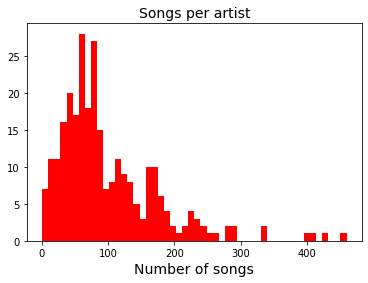

In [33]:
# How many songs do I have for each artist in initial DF?
plt.hist(artists_df.Number_songs,bins=50,color = 'r')
plt.xlabel("Number of songs", fontsize=14)
plt.title("Songs per artist", fontsize=14)
plt.show()

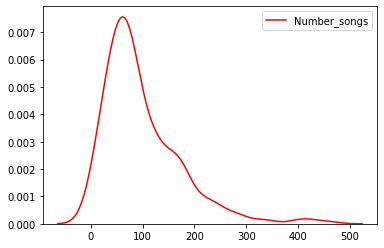

In [34]:
sns.kdeplot(artists_df.Number_songs, color = 'r')
plt.show()

In [35]:
#removing artist with more than 300 songs
artists_df = artists_df[artists_df['Number_songs']<= 300]

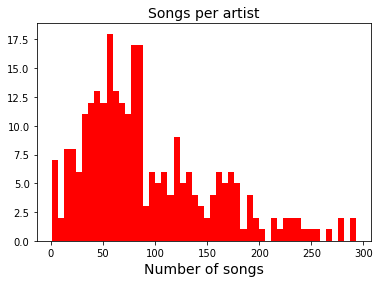

In [36]:
# How many songs do I have for each artist after removing outliers?
plt.hist(artists_df.Number_songs,bins=50,color = 'r')
plt.xlabel("Number of songs", fontsize=14)
plt.title("Songs per artist", fontsize=14)
plt.show()

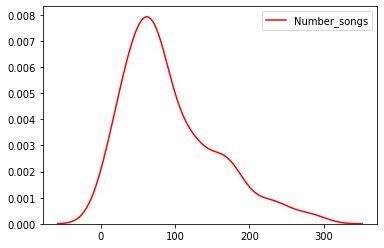

In [37]:
sns.kdeplot(artists_df.Number_songs, color = 'r')
plt.show()

In [38]:
artists_df.sort_values(by = 'Count_words',ascending=False).head(25)

,Artist,Cleaned_lyrics,Number_songs,all_Lyrics,tokens,tokens_lemma,Count_words,Unique_words,Artist_Name,Avg_words,Avg_uniq_words
241,The Game,[you know what the fuck be pissing me off the ...,276,you know what the fuck be pissing me off the o...,"[know, Fword, pissing, Fword, think, running, ...","[know, Fword, piss, Fword, think, run, block, ...",87808,9361,The Game,318.144928,33.916667
184,Nas,[uhh uhh uhhh uhhh uhhh no idea's original t...,247,uhh uhh uhhh uhhh uhhh no idea's original th...,"[idea's, original, there's, nothing, new, sun,...","[idea's, original, there's, nothing, new, sun,...",82482,10215,Nas,333.935223,41.356275
45,Chamillionaire,[we goin lose everything we taught to get mayn...,264,we goin lose everything we taught to get mayn ...,"[goin, lose, everything, taught, get, mayn, do...","[goin, lose, everything, teach, get, mayn, don...",81890,8845,Chamillionaire,310.189394,33.503788
34,Boosie Badazz,[take 'em back hatch take 'em back take 'em ba...,281,take 'em back hatch take 'em back take 'em bac...,"[take, back, hatch, take, back, take, back, th...","[take, back, hatch, take, back, take, back, th...",81642,6895,Boosie Badazz,290.540925,24.537367
246,Too $hort,[eastside beotch yeah you know about that real...,237,eastside beotch yeah you know about that real ...,"[eastside, beotch, know, real, players, real, ...","[eastside, beotch, know, real, players, real, ...",79423,7128,Too Short,335.118143,30.075949
77,Eminem,[came to the world at a time when it was in ne...,192,came to the world at a time when it was in nee...,"[came, world, time, need, villain, asshole, ro...","[come, world, time, need, villain, asshole, ro...",78841,10609,Eminem,410.630208,55.255208
236,T.I.,[aye bend that ass over and let it move back c...,241,aye bend that ass over and let it move back co...,"[aye, bend, ass, let, move, back, come, kick, ...","[aye, bend, ass, let, move, back, come, kick, ...",78220,7913,T.I.,324.564315,32.834025
260,Waka Flocka Flame,[yeah nigga yeah nigga they call me flocka nig...,289,yeah nigga yeah nigga they call me flocka nigg...,"[Nword, Nword, call, flocka, Nword, got, dread...","[Nword, Nword, call, flocka, Nword, get, dread...",77426,6405,Waka Flocka Flame,267.910035,22.162630
2,2Pac,[yo c'mon man what do you mean you don't wanna...,191,yo c'mon man what do you mean you don't wanna ...,"[c'mon, man, mean, wanna, ride, Nword, c'mon, ...","[c'mon, man, mean, wanna, ride, Nword, c'mon, ...",71444,6342,2Pac,374.052356,33.204188
90,Future,[um he came on the scene he's already impacted...,255,um he came on the scene he's already impacted ...,"[um, came, scene, he's, already, impacted, sce...","[um, come, scene, he's, already, impact, scene...",70550,6385,Future,276.666667,25.039216


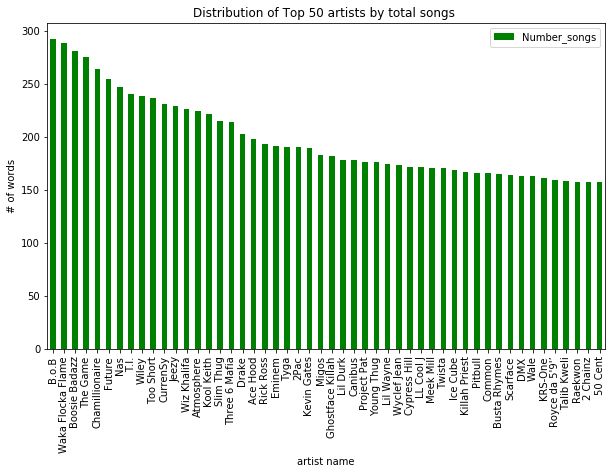

In [39]:
# Create and label an histogram for artists indicators

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
artists_df.sort_values(by = 'Number_songs',ascending=False).head(50).set_index('Artist_Name')['Number_songs'].plot(kind='bar', ax=axes,color='green')
axes.set_title('Distribution of Top 50 artists by total songs ')
axes.set_xlabel("artist name")
axes.set_ylabel("# of words")
axes.legend()
plt.show()

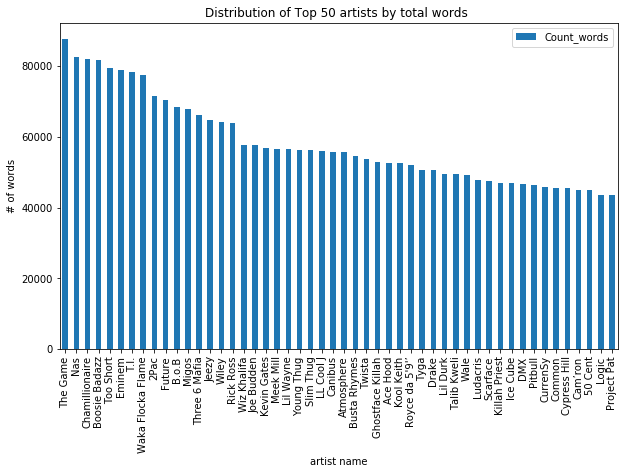

In [40]:
# Create and label an histogram for artists indicators

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

artists_df.sort_values(by = 'Count_words',ascending=False).head(50).set_index('Artist_Name')['Count_words'].plot(kind='bar', ax=axes)

axes.set_title('Distribution of Top 50 artists by total words ')
axes.set_xlabel("artist name")
axes.set_ylabel("# of words")
axes.legend()
plt.show()

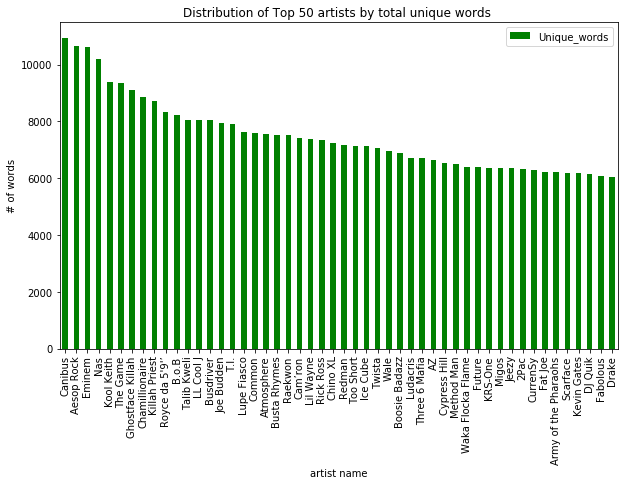

In [41]:
# Create and label an histogram for artists indicators

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

artists_df.sort_values(by = 'Unique_words',ascending=False).head(50).set_index('Artist_Name')['Unique_words'].plot(kind='bar', ax=axes,color='green')
axes.set_title('Distribution of Top 50 artists by total unique words ')
axes.set_xlabel("artist name")
axes.set_ylabel("# of words")
axes.legend()
plt.show()

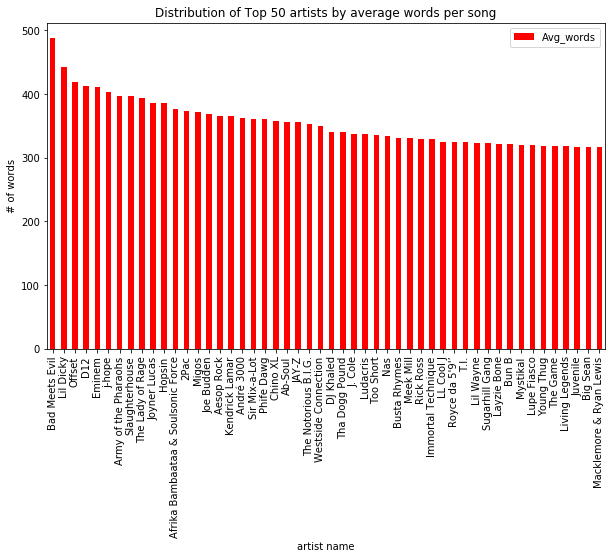

In [42]:
# Create and label an histogram for artists indicators

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

artists_df.sort_values(by = 'Avg_words',ascending=False).head(50).set_index('Artist_Name')['Avg_words'].plot(kind='bar', ax=axes,color='red')
axes.set_title('Distribution of Top 50 artists by average words per song')
axes.set_xlabel("artist name")
axes.set_ylabel("# of words")
axes.legend()
plt.show()

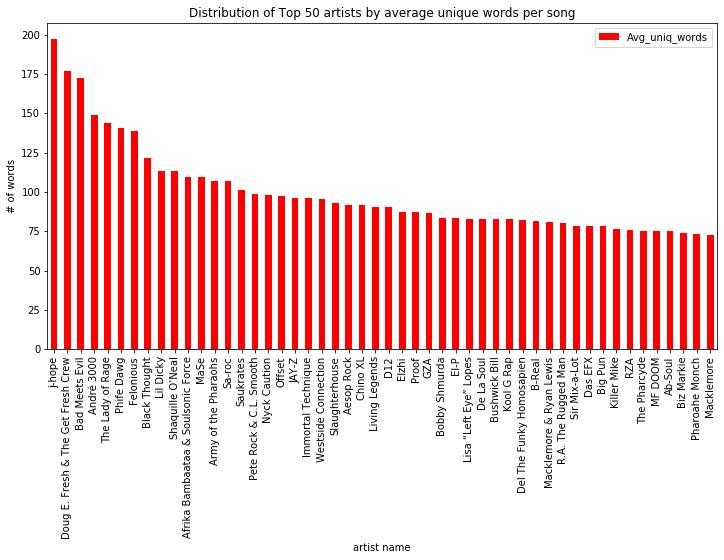

In [43]:
# Create and label an histogram for artists indicators

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

artists_df.sort_values(by = 'Avg_uniq_words',ascending=False).head(50).set_index('Artist_Name')['Avg_uniq_words'].plot(kind='bar', ax=axes,color='red')
axes.set_title('Distribution of Top 50 artists by average unique words per song')
axes.set_xlabel("artist name")
axes.set_ylabel("# of words")
axes.legend()
plt.show()

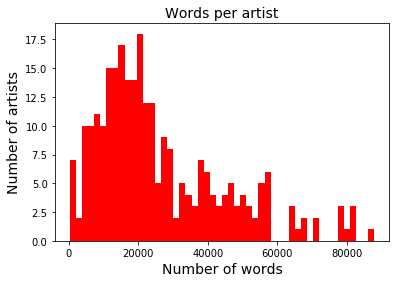

In [44]:
# total words for each artist?
plt.hist(artists_df.Count_words,50,color = 'r')
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Number of artists", fontsize=14)
plt.title("Words per artist", fontsize=14)
plt.show()

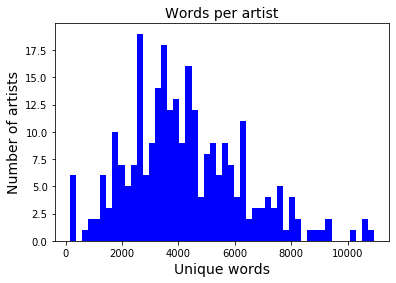

In [45]:
# unique words per artist
plt.hist(artists_df.Unique_words,50,color = 'b')
plt.xlabel("Unique words", fontsize=14)
plt.ylabel("Number of artists", fontsize=14)
plt.title("Words per artist", fontsize=14)
plt.show()

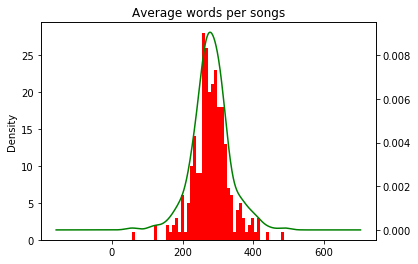

In [46]:
#Showing the distribution of total unique words used
artists_df.Avg_words.plot(kind='hist',color='r',bins=50)
artists_df.Avg_words.plot(kind='kde', secondary_y=True,color='green')
plt.title('Average words per songs')
plt.show()

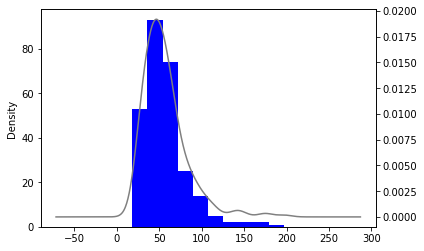

In [47]:
#Showing the distribution of average unique words used
artists_df.Avg_uniq_words.plot(kind='hist',color='blue')
artists_df.Avg_uniq_words.plot(kind='kde', secondary_y=True,color='gray')
plt.show()

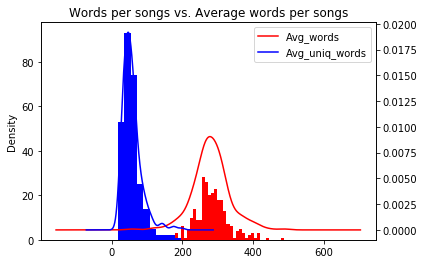

In [48]:
#words per songs vs. unique words
artists_df.Avg_words.plot(kind='hist',color='r',bins=50)
artists_df.Avg_words.plot(kind='kde', secondary_y=True,color='red')
artists_df.Avg_uniq_words.plot(kind='hist',color='blue')
artists_df.Avg_uniq_words.plot(kind='kde', secondary_y=True,color='blue')
plt.title('Words per songs vs. Average words per songs')
plt.legend()
plt.show()

In [49]:
artists_df.head(1)

,Artist,Cleaned_lyrics,Number_songs,all_Lyrics,tokens,tokens_lemma,Count_words,Unique_words,Artist_Name,Avg_words,Avg_uniq_words
0,2 Chainz,[i go hard in the mother fuckin' kitchen half ...,158,i go hard in the mother fuckin' kitchen half t...,"[go, hard, mother, Fword, kitchen, half, thing...","[go, hard, mother, Fword, kitchen, half, thing...",41822,5642,2 Chainz,264.696203,35.708861


In [50]:
lyrics = list(artists_df.tokens_lemma)

In [ ]:
len(lyrics)

In [ ]:
lyrics[0]

In [53]:
all_lyrics = []
for lyric in lyrics:
    for token in lyric:
        all_lyrics.append(token)

In [54]:
len(all_lyrics)

7065477

In [55]:
all_lyrics[:4]

['go', 'hard', 'mother', 'Fword']

In [56]:
lyrics_words=concat_songs(all_lyrics)

In [57]:
lyrics_words[:21]

'go hard mother Fword '

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40,background_color='black').generate_from_text(str(all_lyrics))
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

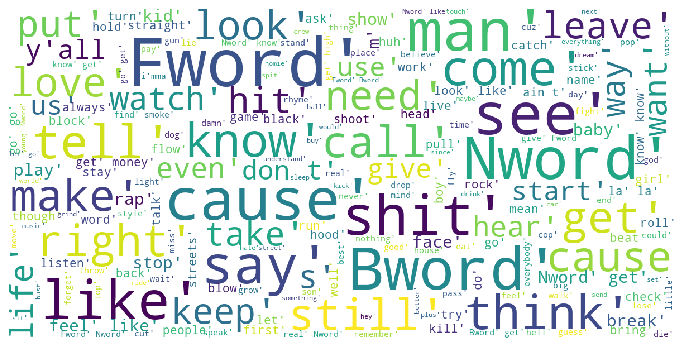

In [51]:
show_wordcloud(lyrics)

In [58]:
#find the words frequency for all lyrics
freq_w = nltk.FreqDist(all_lyrics)

In [59]:
len(freq_w)

129518

In [60]:
#find the 50 most frequent words
most_freq = freq_w.most_common(50)
most_freq

[('get', 186814),
 ('like', 119139),
 ('Nword', 118920),
 ('know', 80519),
 ('Fword', 68420),
 ('go', 65595),
 ('Bword', 63053),
 ('make', 49083),
 ('shit', 48933),
 ('say', 46787),
 ('see', 45645),
 ('come', 43378),
 ('back', 39033),
 ('take', 34066),
 ('love', 33111),
 ('tell', 32506),
 ('time', 31581),
 ('man', 31577),
 ("that's", 30113),
 ('want', 29439),
 ('never', 28939),
 ('wanna', 28244),
 ('let', 28180),
 ("can't", 26883),
 ('money', 26592),
 ('cause', 26325),
 ('keep', 26064),
 ('look', 25551),
 ('think', 25410),
 ('right', 24866),
 ('feel', 23948),
 ('baby', 23894),
 ('give', 23603),
 ('put', 22124),
 ('need', 21987),
 ('life', 21131),
 ('way', 20821),
 ('still', 19631),
 ('try', 19507),
 ('real', 19366),
 ('gotta', 19119),
 ('hit', 18657),
 ('talk', 18421),
 ('call', 18374),
 ('live', 17626),
 ('ass', 17322),
 ('girl', 17088),
 ('run', 17084),
 ("y'all", 16100),
 ('leave', 16093)]

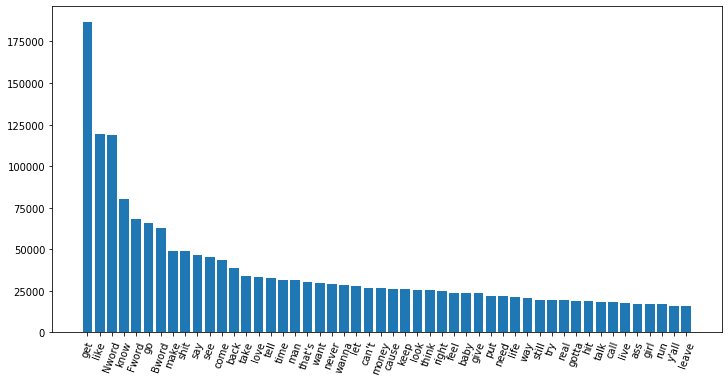

In [61]:
#Visualize the most frequent words
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
plt.bar(range(len(most_freq)), [val[1] for val in most_freq], align='center')
plt.xticks(range(len(most_freq)), [val[0] for val in most_freq])
plt.xticks(rotation=70)
plt.show()

In [ ]:
from os import path
from PIL import Image
import os

In [ ]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

In [ ]:
hiphop_mask = np.array(Image.open(path.join(d, "hip-hop-graph.jpg")))
wc = WordCloud(background_color="white", max_words=2000, mask=hiphop_mask,
               stopwords=stopwords_list, contour_width=3, contour_color='black')

# generate word cloud
wc.generate(lyrics_words)

# store to file
wc.to_file(path.join(d, "test.png"))

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(hiphop_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

## EDA for years

### Features engineering

In [62]:
year_df.head()

,Year_release,Cleaned_lyrics,Number_songs
10,1988,[for years i have been waitin and hesitatin to...,87
11,1989,[yo this one aight though yo me and cool v dis...,118
12,1990,[ah and we do it like this ah and we do it lik...,104
13,1991,[to the beat to the beat y'all to the beat y'...,182
14,1992,[hello is anybody out there alright well check...,159


In [ ]:
#plan
#total words for year
#unique words for year
#words frequency
#word clouts
#words per songs average
#unique words per songs
#TF-IDF
#LDA

In [63]:
#create a column with all the lyrics
year_df['all_Lyrics'] = year_df.Cleaned_lyrics.apply(lambda x: concat_songs(x))

In [64]:
year_df.head()

,Year_release,Cleaned_lyrics,Number_songs,all_Lyrics
10,1988,[for years i have been waitin and hesitatin to...,87,for years i have been waitin and hesitatin to ...
11,1989,[yo this one aight though yo me and cool v dis...,118,yo this one aight though yo me and cool v dis ...
12,1990,[ah and we do it like this ah and we do it lik...,104,ah and we do it like this ah and we do it like...
13,1991,[to the beat to the beat y'all to the beat y'...,182,to the beat to the beat y'all to the beat y'a...
14,1992,[hello is anybody out there alright well check...,159,hello is anybody out there alright well check ...


In [65]:
#tokenize the lyrics
year_df['tokens_w_out_stpw'] = year_df.all_Lyrics.apply(lambda x: get_tokens(x,remove_stop_words=True))

In [66]:
#replace in' with ing
year_df['tokens_w_out_stpw'] = year_df.tokens_w_out_stpw.apply(lambda x: replace_contraction(x))


In [67]:
#Lemmatize verbs and nouns

year_df['tokens_no_stpw_lemma'] = year_df.tokens_w_out_stpw.apply(lambda x: lem_words(x,'n'))

year_df['tokens_no_stpw_lemma'] = year_df.tokens_no_stpw_lemma.apply(lambda x: lem_words(x,'v'))


In [68]:
year_df.head()

,Year_release,Cleaned_lyrics,Number_songs,all_Lyrics,tokens_w_out_stpw,tokens_no_stpw_lemma
10,1988,[for years i have been waitin and hesitatin to...,87,for years i have been waitin and hesitatin to ...,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p..."
11,1989,[yo this one aight though yo me and cool v dis...,118,yo this one aight though yo me and cool v dis ...,"[though, cool, v, dis, dis, dis, gon', dis, go...","[though, cool, v, dis, dis, dis, gon', dis, go..."
12,1990,[ah and we do it like this ah and we do it lik...,104,ah and we do it like this ah and we do it like...,"[like, like, like, like, days, like, scenery, ...","[like, like, like, like, day, like, scenery, r..."
13,1991,[to the beat to the beat y'all to the beat y'...,182,to the beat to the beat y'all to the beat y'a...,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ..."
14,1992,[hello is anybody out there alright well check...,159,hello is anybody out there alright well check ...,"[hello, anybody, alright, well, check, cordial...","[hello, anybody, alright, well, check, cordial..."


In [69]:
#count the words for the entire lyrics
# year_df['Count_words_w_stpw'] = year_df.tokens_stpw_lemma.apply(lambda x: len(x))
year_df['Count_words_no_stpw'] = year_df.tokens_no_stpw_lemma.apply(lambda x: len(x))

In [70]:
#count of unique words used per year
# year_df['Unique_words_w_stpw'] = year_df.tokens_stpw_lemma.apply(lambda x: len(set(x)))
year_df['Unique_words_no_stpw'] = year_df.tokens_no_stpw_lemma.apply(lambda x: len(set(x)))


In [71]:
#average words used per year
year_df['Avg_words'] = year_df.Count_words_no_stpw/year_df.Number_songs


In [72]:
#unique words taking in account number of songs
year_df['Avg_uniq_words'] = year_df.Unique_words_no_stpw/year_df.Number_songs

In [73]:
year_df.head()

,Year_release,Cleaned_lyrics,Number_songs,all_Lyrics,tokens_w_out_stpw,tokens_no_stpw_lemma,Count_words_no_stpw,Unique_words_no_stpw,Avg_words,Avg_uniq_words
10,1988,[for years i have been waitin and hesitatin to...,87,for years i have been waitin and hesitatin to ...,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p...",26228,4972,301.471264,57.149425
11,1989,[yo this one aight though yo me and cool v dis...,118,yo this one aight though yo me and cool v dis ...,"[though, cool, v, dis, dis, dis, gon', dis, go...","[though, cool, v, dis, dis, dis, gon', dis, go...",37848,6513,320.745763,55.194915
12,1990,[ah and we do it like this ah and we do it lik...,104,ah and we do it like this ah and we do it like...,"[like, like, like, like, days, like, scenery, ...","[like, like, like, like, day, like, scenery, r...",29547,5298,284.105769,50.942308
13,1991,[to the beat to the beat y'all to the beat y'...,182,to the beat to the beat y'all to the beat y'a...,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",47598,7183,261.527473,39.467033
14,1992,[hello is anybody out there alright well check...,159,hello is anybody out there alright well check ...,"[hello, anybody, alright, well, check, cordial...","[hello, anybody, alright, well, check, cordial...",48072,8108,302.339623,50.993711


In [74]:
#save data frame
with open('../Data-Cleaning-EDA/cleaned_year_data.pkl', 'wb') as file:
    pickle.dump(year_df, file)

### graphs

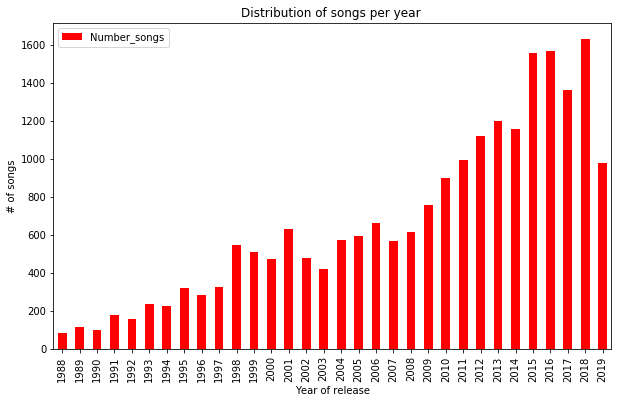

In [75]:
# How many songs do I have each year?

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

year_df.set_index('Year_release')['Number_songs'].plot(kind='bar', ax=axes,color='r')
axes.set_title('Distribution of songs per year ')
axes.set_xlabel("Year of release")
axes.set_ylabel("# of songs")
axes.legend()
plt.show()

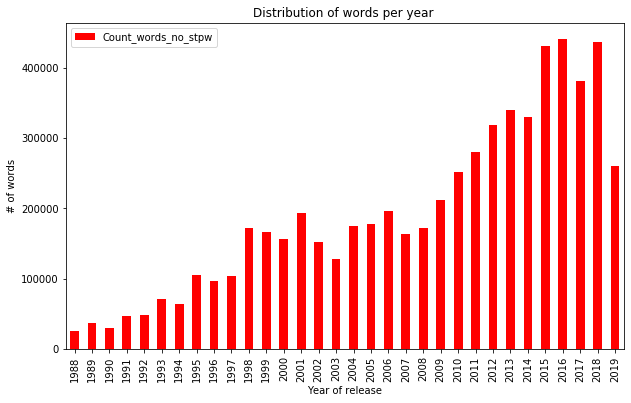

In [76]:
# How many words do I have each year?

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

year_df.set_index('Year_release')['Count_words_no_stpw'].plot(kind='bar', ax=axes,color='r')
axes.set_title('Distribution of words per year ')
axes.set_xlabel("Year of release")
axes.set_ylabel("# of words")
axes.legend()
plt.show()

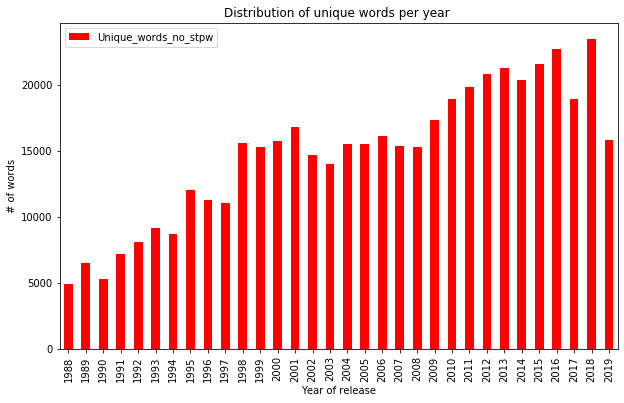

In [77]:
# How many unique words do I have each year?

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

year_df.set_index('Year_release')['Unique_words_no_stpw'].plot(kind='bar', ax=axes,color='r')
axes.set_title('Distribution of unique words per year ')
axes.set_xlabel("Year of release")
axes.set_ylabel("# of words")
axes.legend()
plt.show()

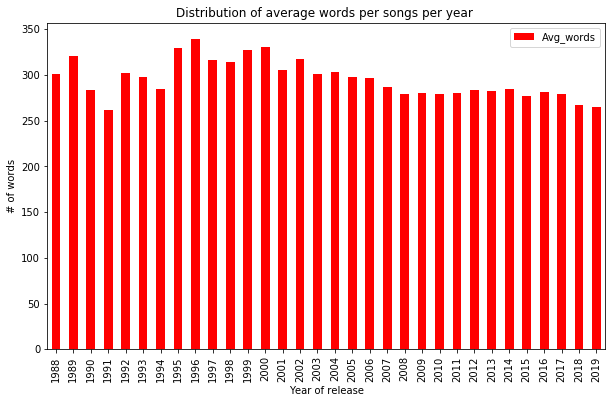

In [78]:
# avg words each year?

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

year_df.set_index('Year_release')['Avg_words'].plot(kind='bar', ax=axes,color='r')
axes.set_title('Distribution of average words per songs per year ')
axes.set_xlabel("Year of release")
axes.set_ylabel("# of words")
axes.legend()
plt.show()

In [79]:
#ANOVA


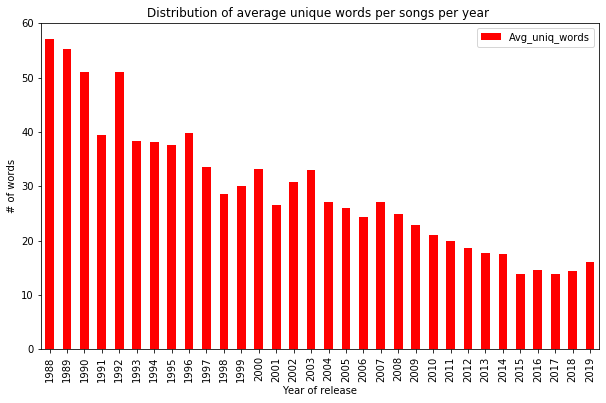

In [80]:
# avg unique words each year?

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

year_df.set_index('Year_release')['Avg_uniq_words'].plot(kind='bar', ax=axes,color='r')
axes.set_title('Distribution of average unique words per songs per year ')
axes.set_xlabel("Year of release")
axes.set_ylabel("# of words")
axes.legend()
plt.show()

In [ ]:
# Words used going down. is it because of streaming?

In [ ]:
#word cloud per year

In [ ]:
year_df.groupby('Year_release').apply(
    lambda x: show_wordcloud(x.tokens_no_stpw_lemma.tolist(), title=f"Year {x.name}")
)

In [ ]:
#words frequency per year

## EDA for the entire data

### Features engineering

In [81]:
tracks_df.head()

,Artist,Title,Album,Year,Lyrics,name,duration_ms,popularity,num_markets,album,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,Lyric_words,Language
1,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",1988-03-29,[Fresh Prince]\nFor years I have been waitin a...,Time to Chill,266040,24,79,"He's The DJ, I'm The Rapper",...,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,"[for, years, i, have, been, waitin, and, hesit...",en
3,Machine Gun Kelly,Candy,Hotel Diablo,2019-07-05,"[Intro: Trippie Redd]\nHaha, Big 14, you know ...",Candy (feat. Trippie Redd),156719,78,79,Hotel Diablo,...,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,"[haha, big, 14, you, know, what, the, fuck, go...",en
4,Big Pun,You Ain’t a Killer,Capital Punishment,1998-04-28,[Verse 1]\nThe harsh realities of life have ta...,You Ain't a Killer,254866,57,79,Capital Punishment (Explicit Version),...,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,"[the, harsh, realities, of, life, have, taken,...",en
6,Das EFX,Buck-Buck,Hold It Down,1995-09-26,*Skoob and Dray giving shoutouts*\n\nChorus:\n...,Buck-Buck,193626,22,78,Hold It Down,...,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,"[skoob, and, dray, giving, shoutouts, chorus, ...",en
9,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,1991-06-11,To the beat...\n\n(To the beat y'all\nTo the b...,To The Beat Y'All,201266,11,77,"Funke, Funke Wisdom",...,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,"[to, the, beat, to, the, beat, y'all, to, the,...",en


In [82]:
tracks_df.columns

Index(['Artist', 'Title', 'Album', 'Year', 'Lyrics', 'name', 'duration_ms',
       'popularity', 'num_markets', 'album', 'disc_number', 'is_explicit',
       'track_number', 'release_date', 'artist', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'Year_release', 'Cleaned_lyrics', 'Lyric_words', 'Language'],
      dtype='object')

In [83]:
#Selecting the features that I need going forward
df = tracks_df[['Artist','Title', 'Album','duration_ms','popularity', 
               'num_markets','danceability', 'energy', 'loudness', 
               'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence', 
               'tempo', 'time_signature','Year_release','Cleaned_lyrics']].reset_index(drop=True)

In [84]:
df.head()

,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...


In [85]:
df['duration_mins'] = df.duration_ms.apply(lambda x: round(float((x/(1000*60))%60),2))

In [86]:
df.head()

,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35


In [87]:
#Create bag of words for each lyrics
df['tokens'] = df.Cleaned_lyrics.apply(lambda x: get_tokens(x,remove_stop_words=True))

In [88]:
#replace in' with ing
df['tokens'] = df.tokens.apply(lambda x: replace_contraction(x))

In [89]:
#Lemmatize verbs and nouns
df['tokens_lemma'] = df.tokens.apply(lambda x: lem_words(x,'n'))

In [90]:
df['tokens_lemma'] = df.tokens_lemma.apply(lambda x: lem_words(x,'v'))

In [91]:
df.head()

,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p..."
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy..."
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, reality, life, take, toll, even, jesus..."
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g..."
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ..."


In [92]:
#count of words per lyrics
df['Count_words'] = df.tokens_lemma.apply(lambda x: len(x))

In [93]:
# get rid of year release 001 
df.drop(df[df['Year_release'] == '0001'].index, inplace=True)

In [94]:
#save data frame
with open('../Data-Cleaning-EDA/cleaned_full_data.pkl', 'wb') as file:
    pickle.dump(df, file)

### Graphs

In [95]:
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,Count_words
count,27512.000000,27512.000000,27512.000000,27512.000000,27512.000000,27512.000000,27512.000000,27512.000000,27512.000000,27512.000000,27512.000000
mean,0.684579,0.691332,-7.033205,0.255747,0.159571,0.015075,0.235388,0.529811,115.622231,3.766467,283.209690
std,0.144697,0.161631,3.132054,0.150410,0.196112,0.095000,0.181823,0.214184,31.965046,1.136053,115.263827
min,0.000000,0.000020,-46.647000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000
25%,0.588000,0.588000,-8.356250,0.137000,0.022800,0.000000,0.104000,0.374000,90.040000,3.190000,214.000000
50%,0.701000,0.708000,-6.455000,0.257000,0.081100,0.000000,0.167000,0.544000,104.238000,3.780000,280.000000
75%,0.794000,0.815000,-4.995000,0.344000,0.220000,0.000005,0.323000,0.694000,140.015250,4.360000,350.000000
max,0.986000,0.998000,0.619000,0.965000,0.995000,0.995000,0.986000,0.989000,228.078000,24.550000,1592.000000


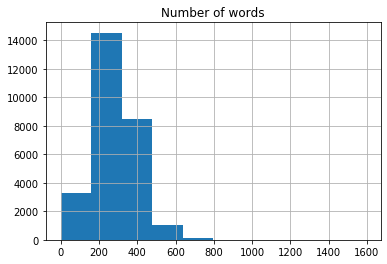

In [96]:
df.Count_words.hist()
plt.title('Number of words')
plt.show()

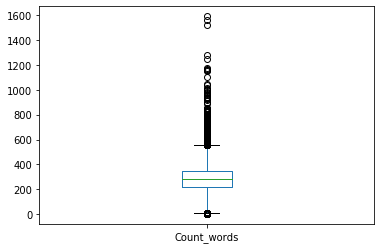

In [97]:
#looking at the box plot for outliers
df.Count_words.plot(kind='box')
plt.show()

In [98]:
#removing any row with no lyrics
df = df[df['Count_words'] > 25]

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27110 entries, 0 to 27513
Data columns (total 22 columns):
Artist              27110 non-null object
Title               27110 non-null object
Album               24807 non-null object
duration_ms         27110 non-null object
popularity          27110 non-null object
num_markets         27110 non-null object
danceability        27110 non-null float64
energy              27110 non-null float64
loudness            27110 non-null float64
speechiness         27110 non-null float64
acousticness        27110 non-null float64
instrumentalness    27110 non-null float64
liveness            27110 non-null float64
valence             27110 non-null float64
tempo               27110 non-null float64
time_signature      27110 non-null object
Year_release        21215 non-null object
Cleaned_lyrics      27110 non-null object
duration_mins       27110 non-null float64
tokens              27110 non-null object
tokens_lemma        27110 non-null object

In [100]:
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,Count_words
count,27110.000000,27110.000000,27110.000000,27110.000000,27110.000000,27110.000000,27110.000000,27110.000000,27110.000000,27110.000000,27110.000000
mean,0.686263,0.693033,-6.982208,0.255802,0.157310,0.013562,0.234734,0.530643,115.780433,3.790304,287.209185
std,0.142385,0.159592,3.048857,0.148763,0.192707,0.089408,0.181322,0.212987,31.746538,1.111950,111.298384
min,0.000000,0.000020,-46.647000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,26.000000
25%,0.590000,0.589000,-8.319750,0.139000,0.022700,0.000000,0.104000,0.375000,90.059000,3.210000,218.000000
50%,0.702000,0.709000,-6.435000,0.257000,0.080400,0.000000,0.166000,0.545000,104.306000,3.790000,281.000000
75%,0.794000,0.816000,-4.983000,0.344000,0.218000,0.000005,0.323000,0.694000,140.018000,4.370000,351.000000
max,0.986000,0.998000,0.619000,0.965000,0.995000,0.986000,0.986000,0.989000,228.078000,24.550000,1592.000000


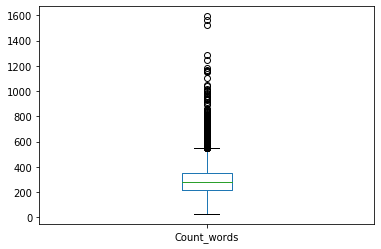

In [101]:
#Checking boxplot
df.Count_words.plot(kind='box')
plt.show()

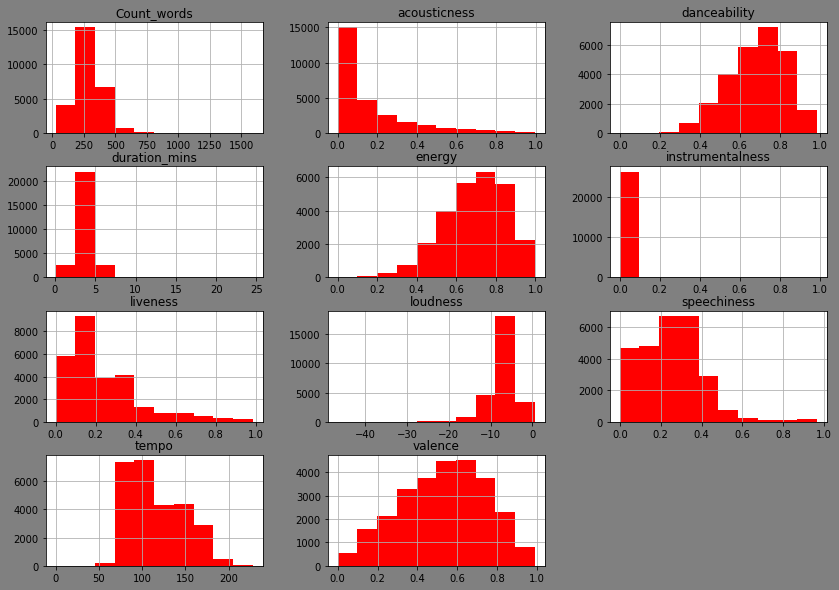

In [102]:
#evaluating all answers for the features to find out if more cleaning needed
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (14,10),facecolor='grey')
ax = fig.gca()
df.hist(ax = ax,color='r');

EXPLAIN THE SPOTIFY RESULT IN LINE WITH DEFINITION
acousticness --> A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

danceability --> Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

energy --> Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

instrumentalness --> Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

liveness --> Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

loudness --> The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

speechiness --> 	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

tempo --> The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

time_signature --> 	An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

valence --> A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


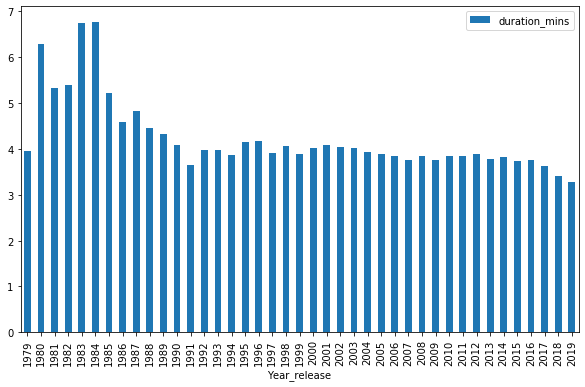

In [103]:
pd.DataFrame(df.groupby('Year_release')['duration_mins'].mean()).plot(kind='bar',figsize = (10,6))
plt.show()

In [104]:
df.columns

Index(['Artist', 'Title', 'Album', 'duration_ms', 'popularity', 'num_markets',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'Year_release', 'Cleaned_lyrics', 'duration_mins', 'tokens',
       'tokens_lemma', 'Count_words'],
      dtype='object')

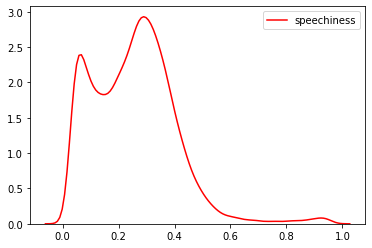

In [105]:
#density of speechiness as not clear in above
sns.kdeplot(df.speechiness, color = 'r')
plt.show()

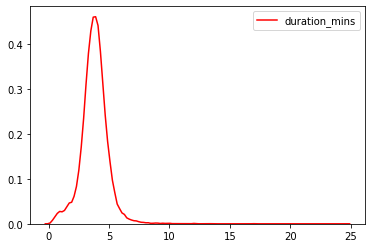

In [106]:
#Looking at the different distribution
sns.kdeplot(df.duration_mins, color = 'r')
plt.show()

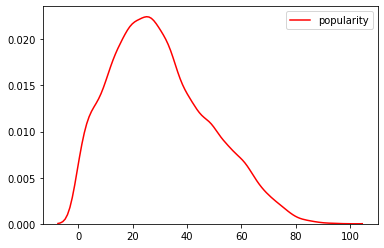

In [107]:
sns.kdeplot(df.popularity, color = 'r')
plt.show()

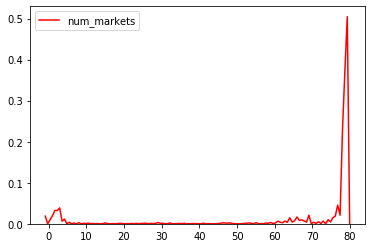

In [108]:
sns.kdeplot(df.num_markets, color = 'r')
plt.show()

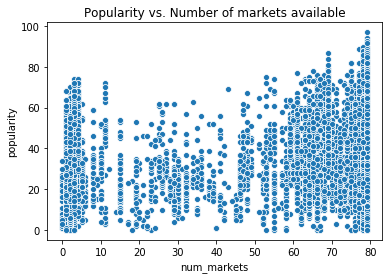

In [109]:
sns.scatterplot(df.num_markets, df.popularity)
plt.title('Popularity vs. Number of markets available',fontsize=12)
plt.show()

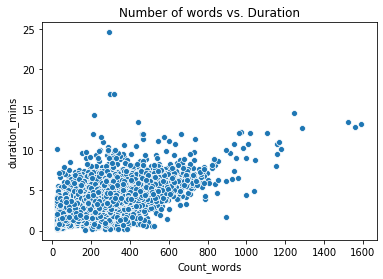

In [110]:
sns.scatterplot(df.Count_words, df.duration_mins)
plt.title('Number of words vs. Duration',fontsize=12)
plt.show()

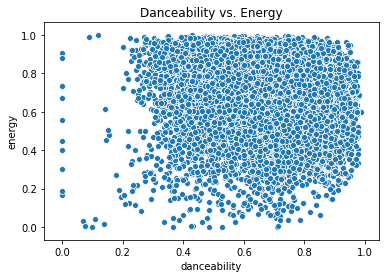

In [111]:
sns.scatterplot(df.danceability, df.energy)
plt.title('Danceability vs. Energy',fontsize=12)
plt.show()

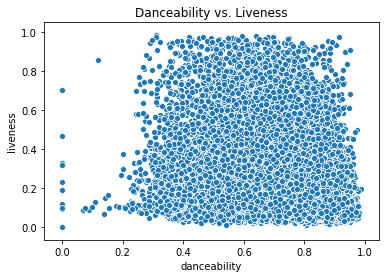

In [112]:
sns.scatterplot(df.danceability, df.liveness)
plt.title('Danceability vs. Liveness',fontsize=12)
plt.show()

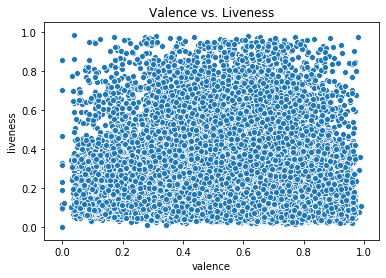

In [113]:
sns.scatterplot(df.valence, df.liveness)
plt.title('Valence vs. Liveness',fontsize=12)
plt.show()

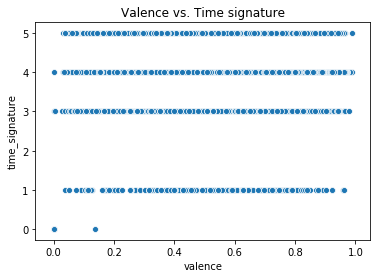

In [114]:
sns.scatterplot(df.valence, df.time_signature)
plt.title('Valence vs. Time signature',fontsize=12)
plt.show()

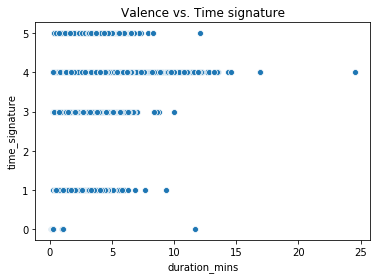

In [115]:
sns.scatterplot(df.duration_mins, df.time_signature)
plt.title('Valence vs. Time signature',fontsize=12)
plt.show()

In [116]:
df.columns

Index(['Artist', 'Title', 'Album', 'duration_ms', 'popularity', 'num_markets',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'Year_release', 'Cleaned_lyrics', 'duration_mins', 'tokens',
       'tokens_lemma', 'Count_words'],
      dtype='object')

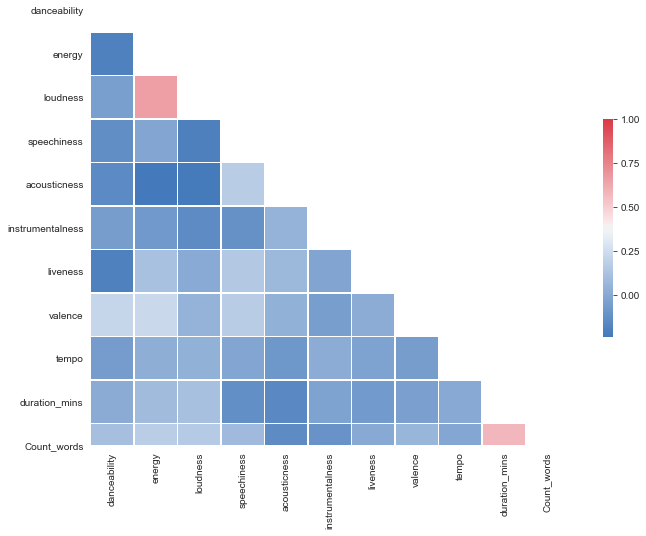

In [117]:
CorrMtx(pd.DataFrame(df[['popularity',
       'num_markets','danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'duration_mins',
       'Count_words']]).corr(),dropDuplicates = True)

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27110 entries, 0 to 27513
Data columns (total 23 columns):
Artist              27110 non-null object
Title               27110 non-null object
Album               24807 non-null object
duration_ms         27110 non-null object
popularity          27110 non-null object
num_markets         27110 non-null object
danceability        27110 non-null float64
energy              27110 non-null float64
loudness            27110 non-null float64
speechiness         27110 non-null float64
acousticness        27110 non-null float64
instrumentalness    27110 non-null float64
liveness            27110 non-null float64
valence             27110 non-null float64
tempo               27110 non-null float64
time_signature      27110 non-null object
Year_release        21215 non-null float64
Cleaned_lyrics      27110 non-null object
duration_mins       27110 non-null float64
tokens              27110 non-null object
tokens_lemma        27110 non-null objec

In [145]:
#Covert years from object to float
df['Year_release'] = df['Year_release'].astype('float64')
#Covert years from object to float
df['popularity'] = df['popularity'].astype('int64')

In [146]:
df.head()

,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p...",234,1980-90s
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",165,2010-20s
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, reality, life, take, toll, even, jesus...",460,1990-00s
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",317,1990-00s
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",304,1990-00s


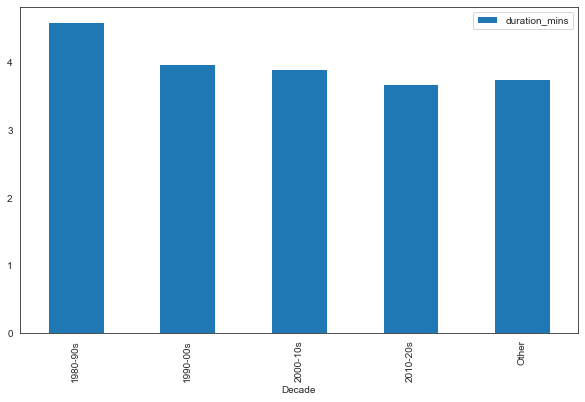

In [137]:
pd.DataFrame(df.groupby('Decade')['duration_mins'].mean()).plot(kind='bar',figsize = (10,6))
plt.show()

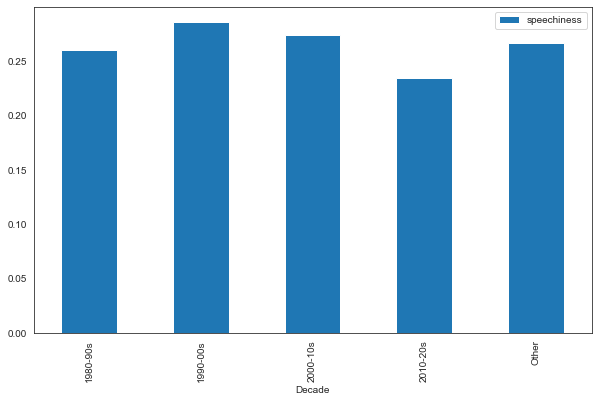

In [139]:
pd.DataFrame(df.groupby('Decade')['speechiness'].mean()).plot(kind='bar',figsize = (10,6))
plt.show()

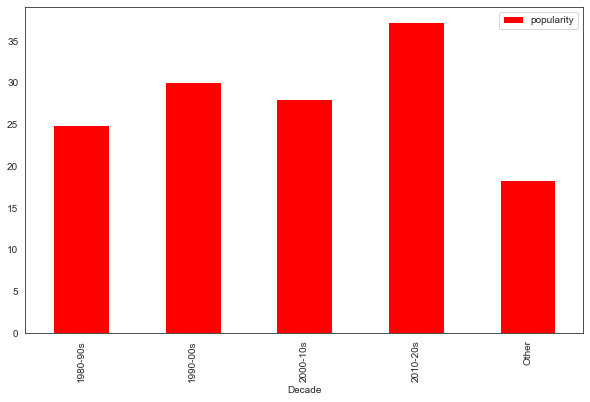

In [149]:
pd.DataFrame(df.groupby('Decade')['popularity'].mean()).plot(kind='bar',figsize = (10,6),color='r')
plt.show()

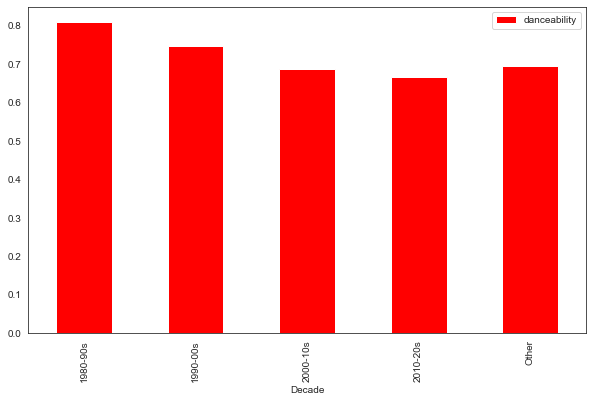

In [150]:
pd.DataFrame(df.groupby('Decade')['danceability'].mean()).plot(kind='bar',figsize = (10,6),color='r')
plt.show()

In [119]:
#save data frame
with open('../Data-Cleaning-EDA/cleaned_full_data.pkl', 'wb') as file:
    pickle.dump(df, file)

## EDA per decades

In [ ]:
### Find frequent words per decade
### Evolution of features per decades
### same later with topics

In [120]:
tracks_df.head()

,Artist,Title,Album,Year,Lyrics,name,duration_ms,popularity,num_markets,album,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,Lyric_words,Language
1,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",1988-03-29,[Fresh Prince]\nFor years I have been waitin a...,Time to Chill,266040,24,79,"He's The DJ, I'm The Rapper",...,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,"[for, years, i, have, been, waitin, and, hesit...",en
3,Machine Gun Kelly,Candy,Hotel Diablo,2019-07-05,"[Intro: Trippie Redd]\nHaha, Big 14, you know ...",Candy (feat. Trippie Redd),156719,78,79,Hotel Diablo,...,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,"[haha, big, 14, you, know, what, the, fuck, go...",en
4,Big Pun,You Ain’t a Killer,Capital Punishment,1998-04-28,[Verse 1]\nThe harsh realities of life have ta...,You Ain't a Killer,254866,57,79,Capital Punishment (Explicit Version),...,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,"[the, harsh, realities, of, life, have, taken,...",en
6,Das EFX,Buck-Buck,Hold It Down,1995-09-26,*Skoob and Dray giving shoutouts*\n\nChorus:\n...,Buck-Buck,193626,22,78,Hold It Down,...,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,"[skoob, and, dray, giving, shoutouts, chorus, ...",en
9,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,1991-06-11,To the beat...\n\n(To the beat y'all\nTo the b...,To The Beat Y'All,201266,11,77,"Funke, Funke Wisdom",...,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,"[to, the, beat, to, the, beat, y'all, to, the,...",en


In [121]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27514 entries, 1 to 55008
Data columns (total 31 columns):
Artist              27514 non-null object
Title               27514 non-null object
Album               25162 non-null object
Year                21489 non-null object
Lyrics              27514 non-null object
name                27514 non-null object
duration_ms         27514 non-null object
popularity          27514 non-null object
num_markets         27514 non-null object
album               27514 non-null object
disc_number         27514 non-null object
is_explicit         27514 non-null object
track_number        27514 non-null object
release_date        27514 non-null object
artist              27514 non-null object
danceability        27514 non-null float64
energy              27514 non-null float64
key                 27514 non-null object
loudness            27514 non-null float64
mode                27514 non-null object
speechiness         27514 non-null float64
acous

In [ ]:
#Covert years from object to float
df['Year_release'] = df['Year_release'].astype('float64')

In [122]:
#Create the decades columns in the dataframe
df['Decade'] = df.Year_release.apply(lambda x: get_decade(x))

In [123]:
# Group the lyrics by decades
decade_lyrics_df = pd.DataFrame(df.groupby(['Decade'])['Cleaned_lyrics'].apply(list)).reset_index()

In [124]:
decade_lyrics_df['Number_songs'] = decade_lyrics_df.Cleaned_lyrics.apply(lambda x: len(x))

In [125]:
decade_lyrics_df.head()

,Decade,Cleaned_lyrics,Number_songs
0,1980-90s,[for years i have been waitin and hesitatin to...,286
1,1990-00s,[the harsh realities of life have taken toll e...,2869
2,2000-10s,[pushin' pushin' pushin' pushin' i live my l...,5723
3,2010-20s,[haha big 14 you know what the fuck going on ...,12336
4,Other,[hey yo the same og yo thats my shit switch cd...,5896


In [126]:
#create a column with all the lyrics
decade_lyrics_df['all_Lyrics'] = decade_lyrics_df.Cleaned_lyrics.apply(lambda x: concat_songs(x))

In [127]:
#Cleaning and transforming to tokens
#Create bag of words for each lyrics
decade_lyrics_df['tokens'] = decade_lyrics_df.all_Lyrics.apply(lambda x: get_tokens(x,remove_stop_words=True))
decade_lyrics_df['tokens'] = decade_lyrics_df.tokens.apply(lambda x: replace_contraction(x))
#Lemmatize verbs and nouns
decade_lyrics_df['tokens_lemma'] = decade_lyrics_df.tokens.apply(lambda x: lem_words(x,'n'))
decade_lyrics_df['tokens_lemma'] = decade_lyrics_df.tokens.apply(lambda x: lem_words(x,'v'))
#count of words per lyrics
decade_lyrics_df['Count_words'] = decade_lyrics_df.tokens_lemma.apply(lambda x: len(x))

In [128]:
decade_lyrics_df.head()

,Decade,Cleaned_lyrics,Number_songs,all_Lyrics,tokens,tokens_lemma,Count_words
0,1980-90s,[for years i have been waitin and hesitatin to...,286,for years i have been waitin and hesitatin to ...,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",91982
1,1990-00s,[the harsh realities of life have taken toll e...,2869,the harsh realities of life have taken toll ev...,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",907135
2,2000-10s,[pushin' pushin' pushin' pushin' i live my l...,5723,pushin' pushin' pushin' pushin' i live my li...,"[pushing, pushing, pushing, pushing, live, lif...","[push, push, push, push, live, life, day, time...",1727187
3,2010-20s,[haha big 14 you know what the fuck going on ...,12336,haha big 14 you know what the fuck going on ...,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",3467243
4,Other,[hey yo the same og yo thats my shit switch cd...,5896,hey yo the same og yo thats my shit switch cds...,"[hey, og, thats, shit, switch, cds, threw, nas...","[hey, og, thats, shit, switch, cds, throw, nas...",1592694


In [129]:
#average words used per decade
decade_lyrics_df['Avg_words'] = decade_lyrics_df.Count_words/decade_lyrics_df.Number_songs

In [130]:
decade_lyrics_df.head()

,Decade,Cleaned_lyrics,Number_songs,all_Lyrics,tokens,tokens_lemma,Count_words,Avg_words
0,1980-90s,[for years i have been waitin and hesitatin to...,286,for years i have been waitin and hesitatin to ...,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",91982,321.615385
1,1990-00s,[the harsh realities of life have taken toll e...,2869,the harsh realities of life have taken toll ev...,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",907135,316.185082
2,2000-10s,[pushin' pushin' pushin' pushin' i live my l...,5723,pushin' pushin' pushin' pushin' i live my li...,"[pushing, pushing, pushing, pushing, live, lif...","[push, push, push, push, live, life, day, time...",1727187,301.797484
3,2010-20s,[haha big 14 you know what the fuck going on ...,12336,haha big 14 you know what the fuck going on ...,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",3467243,281.067040
4,Other,[hey yo the same og yo thats my shit switch cd...,5896,hey yo the same og yo thats my shit switch cds...,"[hey, og, thats, shit, switch, cds, threw, nas...","[hey, og, thats, shit, switch, cds, throw, nas...",1592694,270.131275


In [131]:
#Unique words per decade
decade_lyrics_df['Unique_words_no_stpw'] = decade_lyrics_df.tokens_lemma.apply(lambda x: len(set(x)))

In [132]:
#unique words taking in account number of songs
decade_lyrics_df['Avg_uniq_words'] = decade_lyrics_df.Unique_words_no_stpw/decade_lyrics_df.Number_songs

In [133]:
decade_lyrics_df.head()

,Decade,Cleaned_lyrics,Number_songs,all_Lyrics,tokens,tokens_lemma,Count_words,Avg_words,Unique_words_no_stpw,Avg_uniq_words
0,1980-90s,[for years i have been waitin and hesitatin to...,286,for years i have been waitin and hesitatin to ...,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",91982,321.615385,10498,36.706294
1,1990-00s,[the harsh realities of life have taken toll e...,2869,the harsh realities of life have taken toll ev...,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",907135,316.185082,41958,14.624608
2,2000-10s,[pushin' pushin' pushin' pushin' i live my l...,5723,pushin' pushin' pushin' pushin' i live my li...,"[pushing, pushing, pushing, pushing, live, lif...","[push, push, push, push, live, life, day, time...",1727187,301.797484,60951,10.650183
3,2010-20s,[haha big 14 you know what the fuck going on ...,12336,haha big 14 you know what the fuck going on ...,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",3467243,281.067040,75356,6.108625
4,Other,[hey yo the same og yo thats my shit switch cd...,5896,hey yo the same og yo thats my shit switch cds...,"[hey, og, thats, shit, switch, cds, threw, nas...","[hey, og, thats, shit, switch, cds, throw, nas...",1592694,270.131275,59418,10.077680


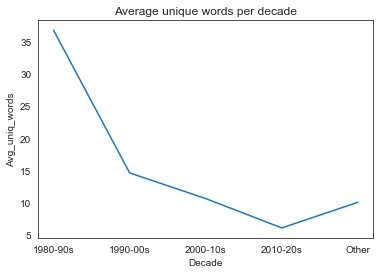

In [134]:
sns.lineplot(decade_lyrics_df.Decade, decade_lyrics_df.Avg_uniq_words)
plt.title('Average unique words per decade',fontsize=12)
plt.show()

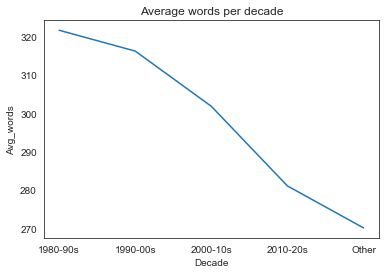

In [135]:
sns.lineplot(decade_lyrics_df.Decade, decade_lyrics_df.Avg_words)
plt.title('Average words per decade',fontsize=12)
plt.show()